In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd
from tqdm import tqdm

In [2]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
learningRate = 2e-4
batchSize = 128
imageSize = 64
channelsImage = 3  
noiseDim = 100
numEpochs = 50
featuresDisc = 64 
featuresGen = 64 
# Beta hyperparam for Adam optimizers
beta = 0.5


Device: cuda


In [3]:
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 79774191.39it/s]


Extracting ./dataset/CIFAR10data/cifar-10-python.tar.gz to ./dataset/CIFAR10data


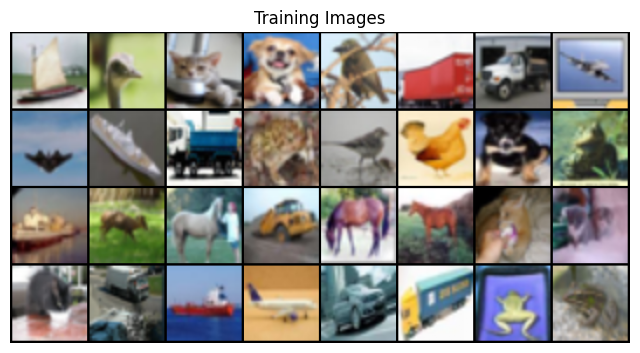

In [4]:
# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

disc = Discriminator(3, 64).to(device)
initialize_weights(disc)

In [7]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            
            self.Gnet(channels_noise, features_g * 16, 4, 1, 0),  
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),  
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            
            nn.Tanh(),
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

gen = Generator(noiseDim, channelsImage, featuresGen).to(device)
initialize_weights(gen)

In [ ]:
optimGenerator = optim.Adam(gen.parameters(), lr=learningRate, betas=(beta, 0.999))
optimDiscriminator = optim.Adam(disc.parameters(), lr=learningRate, betas=(beta, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, noiseDim, 1, 1).to(device) 
step = 0

In [9]:
gen.train(),disc.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): C

In [10]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""
    
    
    DEFAULT_BLOCK_INDEX = 3

    BLOCK_INDEX_BY_DIM = {
        64: 0,   
        192: 1,  
        768: 2,  
        2048: 3  
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: 
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1 
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2 
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)
def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
    """get fretched distance"""
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 60.5MB/s]


In [11]:
GenLoss = []
DiscLoss = []
img_list = []
FID_list = []
iters = 0

time_start = time.time() 
for epoch in range(numEpochs):
    epoch = epoch+1
    
    for batch_idx, data in tqdm(enumerate(dataloader,0)):
       
        real = data[0].to(device)
        noise = torch.randn(batchSize, noiseDim, 1, 1).to(device)
        fake = gen(noise)

        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        optimDiscriminator.step()

        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())
        
        if (iters % 500 == 0) or ((epoch == numEpochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    
    
    fretchet_dist=calculate_fretchet(real,fake,model)
    FID_list.append(fretchet_dist)
    
    print( f'\nEpoch [{epoch}/{numEpochs}] \
              Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f} FID:{fretchet_dist:.3f} ')
        
time_end = time.time()
print('\n\n elapsed time：%.2f s.'%(time_end-time_start))

391it [01:35,  4.11it/s]



Epoch [1/50]               Loss Discriminator: 0.320, loss Generator: 1.698 FID:362.694 


391it [01:28,  4.40it/s]



Epoch [2/50]               Loss Discriminator: 0.576, loss Generator: 1.032 FID:435.257 


391it [01:28,  4.43it/s]



Epoch [3/50]               Loss Discriminator: 0.586, loss Generator: 0.965 FID:416.090 


391it [01:28,  4.44it/s]



Epoch [4/50]               Loss Discriminator: 0.454, loss Generator: 1.281 FID:298.845 


391it [01:28,  4.44it/s]



Epoch [5/50]               Loss Discriminator: 0.701, loss Generator: 0.746 FID:256.160 


391it [01:28,  4.43it/s]



Epoch [6/50]               Loss Discriminator: 0.648, loss Generator: 0.930 FID:234.941 


391it [01:28,  4.44it/s]



Epoch [7/50]               Loss Discriminator: 0.611, loss Generator: 1.030 FID:236.895 


391it [01:28,  4.43it/s]



Epoch [8/50]               Loss Discriminator: 0.602, loss Generator: 1.147 FID:215.465 


391it [01:27,  4.45it/s]



Epoch [9/50]               Loss Discriminator: 0.621, loss Generator: 0.994 FID:239.583 


391it [01:27,  4.45it/s]



Epoch [10/50]               Loss Discriminator: 0.632, loss Generator: 1.068 FID:213.857 


391it [01:27,  4.45it/s]



Epoch [11/50]               Loss Discriminator: 0.633, loss Generator: 0.940 FID:215.208 


391it [01:27,  4.45it/s]



Epoch [12/50]               Loss Discriminator: 0.604, loss Generator: 0.851 FID:202.414 


391it [01:28,  4.43it/s]



Epoch [13/50]               Loss Discriminator: 0.708, loss Generator: 1.451 FID:194.954 


391it [01:27,  4.45it/s]



Epoch [14/50]               Loss Discriminator: 0.621, loss Generator: 1.011 FID:201.288 


391it [01:27,  4.45it/s]



Epoch [15/50]               Loss Discriminator: 0.636, loss Generator: 0.799 FID:201.456 


391it [01:27,  4.46it/s]



Epoch [16/50]               Loss Discriminator: 0.619, loss Generator: 0.930 FID:187.819 


391it [01:27,  4.46it/s]



Epoch [17/50]               Loss Discriminator: 0.698, loss Generator: 0.769 FID:201.536 


391it [01:27,  4.45it/s]



Epoch [18/50]               Loss Discriminator: 0.638, loss Generator: 0.994 FID:182.895 


391it [01:27,  4.47it/s]



Epoch [19/50]               Loss Discriminator: 0.567, loss Generator: 0.973 FID:186.715 


391it [01:27,  4.46it/s]



Epoch [20/50]               Loss Discriminator: 0.591, loss Generator: 1.147 FID:192.888 


391it [01:27,  4.46it/s]



Epoch [21/50]               Loss Discriminator: 0.608, loss Generator: 0.945 FID:187.517 


391it [01:27,  4.46it/s]



Epoch [22/50]               Loss Discriminator: 0.518, loss Generator: 1.916 FID:196.119 


391it [01:27,  4.46it/s]



Epoch [23/50]               Loss Discriminator: 0.591, loss Generator: 0.980 FID:192.402 


391it [01:27,  4.47it/s]



Epoch [24/50]               Loss Discriminator: 0.613, loss Generator: 0.976 FID:187.113 


391it [01:27,  4.47it/s]



Epoch [25/50]               Loss Discriminator: 0.643, loss Generator: 0.895 FID:188.713 


391it [01:27,  4.46it/s]



Epoch [26/50]               Loss Discriminator: 0.601, loss Generator: 1.112 FID:187.444 


391it [01:27,  4.47it/s]



Epoch [27/50]               Loss Discriminator: 0.521, loss Generator: 1.041 FID:187.996 


391it [01:27,  4.47it/s]



Epoch [28/50]               Loss Discriminator: 0.508, loss Generator: 1.280 FID:183.323 


391it [01:27,  4.47it/s]



Epoch [29/50]               Loss Discriminator: 0.443, loss Generator: 1.222 FID:186.018 


391it [01:27,  4.47it/s]



Epoch [30/50]               Loss Discriminator: 0.564, loss Generator: 1.156 FID:184.642 


391it [01:27,  4.47it/s]



Epoch [31/50]               Loss Discriminator: 0.537, loss Generator: 1.304 FID:174.513 


391it [01:27,  4.48it/s]



Epoch [32/50]               Loss Discriminator: 0.434, loss Generator: 1.055 FID:186.379 


391it [01:27,  4.48it/s]



Epoch [33/50]               Loss Discriminator: 0.605, loss Generator: 2.214 FID:183.378 


391it [01:27,  4.47it/s]



Epoch [34/50]               Loss Discriminator: 0.575, loss Generator: 0.838 FID:181.372 


391it [01:27,  4.47it/s]



Epoch [35/50]               Loss Discriminator: 0.597, loss Generator: 1.087 FID:186.869 


391it [01:27,  4.47it/s]



Epoch [36/50]               Loss Discriminator: 0.724, loss Generator: 1.190 FID:172.076 


391it [01:27,  4.47it/s]



Epoch [37/50]               Loss Discriminator: 0.510, loss Generator: 1.095 FID:186.104 


391it [01:27,  4.47it/s]



Epoch [38/50]               Loss Discriminator: 0.406, loss Generator: 1.437 FID:189.518 


391it [01:27,  4.47it/s]



Epoch [39/50]               Loss Discriminator: 0.494, loss Generator: 2.054 FID:187.860 


391it [01:27,  4.48it/s]



Epoch [40/50]               Loss Discriminator: 0.483, loss Generator: 1.299 FID:174.314 


391it [01:27,  4.47it/s]



Epoch [41/50]               Loss Discriminator: 0.672, loss Generator: 1.691 FID:184.862 


391it [01:27,  4.48it/s]



Epoch [42/50]               Loss Discriminator: 0.381, loss Generator: 1.502 FID:175.743 


391it [01:27,  4.48it/s]



Epoch [43/50]               Loss Discriminator: 0.533, loss Generator: 1.463 FID:182.942 


391it [01:27,  4.47it/s]



Epoch [44/50]               Loss Discriminator: 0.412, loss Generator: 1.579 FID:181.550 


391it [01:27,  4.48it/s]



Epoch [45/50]               Loss Discriminator: 0.500, loss Generator: 1.231 FID:178.853 


391it [01:27,  4.47it/s]



Epoch [46/50]               Loss Discriminator: 0.367, loss Generator: 1.740 FID:188.688 


391it [01:27,  4.47it/s]



Epoch [47/50]               Loss Discriminator: 0.394, loss Generator: 1.633 FID:177.325 


391it [01:27,  4.48it/s]



Epoch [48/50]               Loss Discriminator: 0.524, loss Generator: 2.437 FID:180.077 


391it [01:27,  4.47it/s]



Epoch [49/50]               Loss Discriminator: 0.341, loss Generator: 1.956 FID:183.567 


391it [01:27,  4.47it/s]



Epoch [50/50]               Loss Discriminator: 0.487, loss Generator: 1.553 FID:222.765 


 elapsed time：5225.13 s.


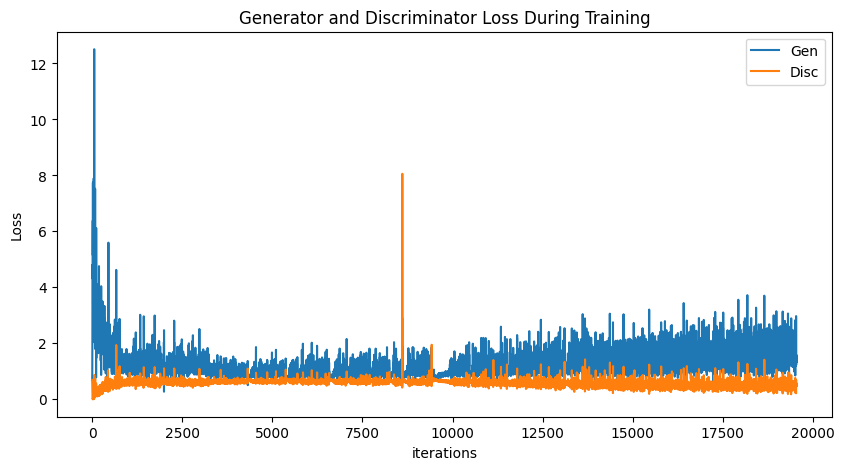

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

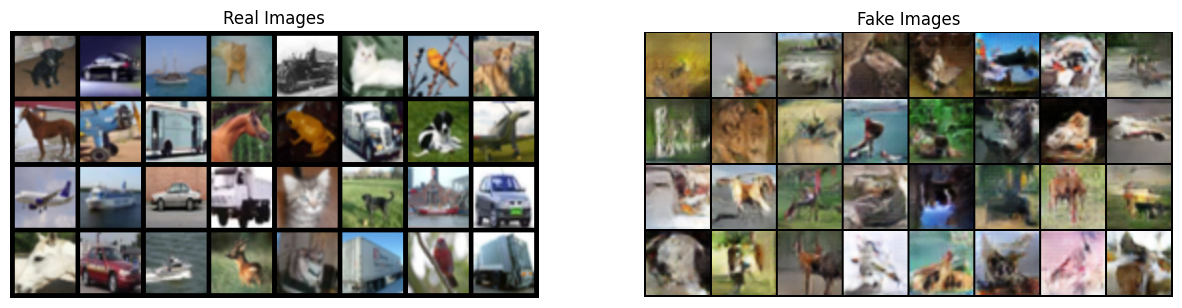

In [13]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

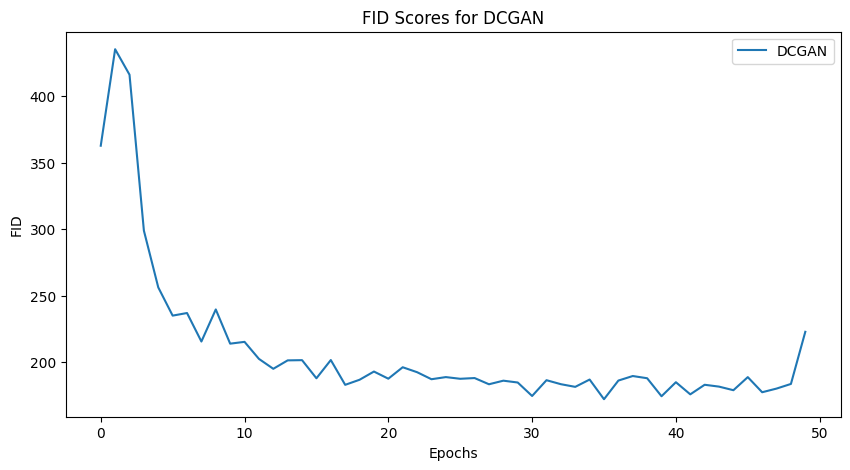

In [14]:
plt.figure(figsize=(10,5))
plt.title("FID Scores for DCGAN")
plt.plot(FID_list,label="DCGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.show()

In [15]:
np.mean(FID_list), FID_list[-1]

(208.74003572323082, 222.76482332860442)